# U.S. Net Domestic Migration by County: 2020-2022
### 1. Introduction

The dataset explored in this project is from [census.gov](https://www.census.gov/data/datasets/time-series/demo/popest/2020s-counties-total.html#v2022). Labeled `CO-EST2022-COMP`, this dataset contains resident population change by county from 2020 to 2022. This project aims to recreate the U.S. Census Bureau's dot-density map, found here:

[Two Years Into Pandemic, Domestic Migration Trends Shifted](https://www.census.gov/library/stories/2023/03/domestic-migration-trends-shifted.html#titlecore-ebc32996d9)

In [1]:
import pandas as pd
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

### 2. Download the dataset

In [2]:
file = 'https://www2.census.gov/programs-surveys/popest/tables/2020-2022/counties/totals/co-est2022-comp.xlsx'
# file = 'data/co-est2022-comp.xlsx'

df = pd.read_excel(file, sheet_name='CO-EST2022-COMP',
                   skiprows=4, usecols=[0, 14], header=0,
                   names=['geographic_area', 'domestic'])
display(df.head())
display(df.info())

CO-EST2022-COMP


,geographic_area,domestic
0,United States,0.0
1,".Autauga County, Alabama",847.0
2,".Baldwin County, Alabama",15543.0
3,".Barbour County, Alabama",-260.0
4,".Bibb County, Alabama",-149.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3153 entries, 0 to 3152
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geographic_area  3153 non-null   object 
 1   domestic         3145 non-null   float64
dtypes: float64(1), object(1)
memory usage: 49.4+ KB


None

### 3. Clean and wrangle

In [3]:
# check what are the null values
df[df['domestic'].isna()]

,geographic_area,domestic
3145,(X) Not applicable.,NaN
3146,1 Total population change includes a residual....,NaN
3147,2 Net international migration for the United S...,NaN
3148,Note: The estimates are developed from a base ...,NaN
3149,Suggested Citation:,NaN
3150,Annual and Cumulative Estimates of the Compone...,NaN
3151,"Source: U.S. Census Bureau, Population Division",NaN
3152,Release Date: March 2023,NaN


In [4]:
# remove those rows
df = df[df['domestic'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3145 entries, 0 to 3144
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geographic_area  3145 non-null   object 
 1   domestic         3145 non-null   float64
dtypes: float64(1), object(1)
memory usage: 73.7+ KB


In [5]:
# convert column from float to int
df['domestic'] = df['domestic'].astype('int')
df.head()

,geographic_area,domestic
0,United States,0
1,".Autauga County, Alabama",847
2,".Baldwin County, Alabama",15543
3,".Barbour County, Alabama",-260
4,".Bibb County, Alabama",-149


In [6]:
# check if all rows contains a comma, i.e. are in `County, State` format
df[~df['geographic_area'].str.contains(',',)]

,geographic_area,domestic
0,United States,0


In [7]:
# remove top-level USA row
df = df[df['geographic_area'].str.contains(',',)]
df.head()

,geographic_area,domestic
1,".Autauga County, Alabama",847
2,".Baldwin County, Alabama",15543
3,".Barbour County, Alabama",-260
4,".Bibb County, Alabama",-149
5,".Blount County, Alabama",753


In [8]:
# split into separate `county_name` and `state_name` columns
df[['county_name', 'state_name']] = df['geographic_area'].str.split(', ', 1, expand=True)
df.drop(columns='geographic_area', inplace=True)
df.head()

,domestic,county_name,state_name
1,847,.Autauga County,Alabama
2,15543,.Baldwin County,Alabama
3,-260,.Barbour County,Alabama
4,-149,.Bibb County,Alabama
5,753,.Blount County,Alabama


In [9]:
# strip off the prefixed '.'
df['county_name'] = df['county_name'].str.strip('.')
df.head()

,domestic,county_name,state_name
1,847,Autauga County,Alabama
2,15543,Baldwin County,Alabama
3,-260,Barbour County,Alabama
4,-149,Bibb County,Alabama
5,753,Blount County,Alabama


In [10]:
# check if any null values
df.isnull().values.any()

False

In [11]:
# how many counties
df.count()

domestic       3144
county_name    3144
state_name     3144
dtype: int64

### 4. Download the cartographic boundary shapefile for all the counties

From https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html#ti1804832544:

- 1 : 5,000,000 (national) [shapefile](https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_5m.zip) \[2.6 MB\]

In [12]:
import geopandas as gpd
import random

zip_file = 'zip://data/cb_2021_us_county_5m.zip'

df_counties = gpd.read_file(zip_file)
df_counties = df_counties[['GEOID', 'NAME', 'NAMELSAD', 'STUSPS', 'STATE_NAME', 'geometry']]
df_counties.columns = ['geoid', 'county', 'county_name', 'state', 'state_name', 'geometry']
df_counties.head()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


,geoid,county,county_name,state,state_name,geometry
0,01059,Franklin,Franklin County,AL,Alabama,"POLYGON ((-88.16591 34.38093, -88.16563 34.383..."
1,06057,Nevada,Nevada County,CA,California,"POLYGON ((-121.27953 39.23054, -121.25918 39.2..."
2,26031,Cheboygan,Cheboygan County,MI,Michigan,"POLYGON ((-84.73269 45.28938, -84.73239 45.787..."
3,29119,McDonald,McDonald County,MO,Missouri,"POLYGON ((-94.61831 36.76656, -94.06890 36.747..."
4,31157,Scotts Bluff,Scotts Bluff County,NE,Nebraska,"POLYGON ((-104.05293 41.90614, -104.05299 41.9..."


In [13]:
df_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geoid        3234 non-null   object  
 1   county       3234 non-null   object  
 2   county_name  3234 non-null   object  
 3   state        3234 non-null   object  
 4   state_name   3234 non-null   object  
 5   geometry     3234 non-null   geometry
dtypes: geometry(1), object(5)
memory usage: 151.7+ KB


In [14]:
# merge geometries to the `migraton` dataframe
df_merged = pd.merge(df, df_counties.drop(columns=['county', 'state'])
                     , on=['county_name', 'state_name']
                     , how='left')
df_merged.head()

,domestic,county_name,state_name,geoid,geometry
0,847,Autauga County,Alabama,01001,"POLYGON ((-86.91760 32.66417, -86.81657 32.660..."
1,15543,Baldwin County,Alabama,01003,"POLYGON ((-88.02927 30.22271, -88.02399 30.230..."
2,-260,Barbour County,Alabama,01005,"POLYGON ((-85.74142 31.61961, -85.72983 31.632..."
3,-149,Bibb County,Alabama,01007,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
4,753,Blount County,Alabama,01009,"POLYGON ((-86.96211 33.86769, -86.94766 33.861..."


In [15]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3144 entries, 0 to 3143
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   domestic     3144 non-null   int64   
 1   county_name  3144 non-null   object  
 2   state_name   3144 non-null   object  
 3   geoid        3135 non-null   object  
 4   geometry     3135 non-null   geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 147.4+ KB


In [16]:
# check which rows have null values in the `geoid` and `geometry` columns
df_merged[df_merged['geoid'].isna()]

,domestic,county_name,state_name,geoid,geometry
309,173,Capitol Planning Region,Connecticut,NaN,None
310,-3145,Greater Bridgeport Planning Region,Connecticut,NaN,None
311,3003,Lower Connecticut River Valley Planning Region,Connecticut,NaN,None
312,2516,Naugatuck Valley Planning Region,Connecticut,NaN,None
313,1190,Northeastern Connecticut Planning Region,Connecticut,NaN,None
314,1453,Northwest Hills Planning Region,Connecticut,NaN,None
315,197,South Central Connecticut Planning Region,Connecticut,NaN,None
316,-408,Southeastern Connecticut Planning Region,Connecticut,NaN,None
317,-5055,Western Connecticut Planning Region,Connecticut,NaN,None


Per the [Office of the Federal Register](https://www.federalregister.gov/documents/2020/12/14/2020-27459/change-to-county-equivalents-in-the-state-of-connecticut), Connecticut is transitioning to `Planning Regions` (county equivalents), which the Census Bureau proposed to implement in 2023.

The planning regions and their new FIPS codes:

| Name                                           | FIPS state-county code  |
|------------------------------------------------|-------------------------|
| Capitol Planning Region                        | 09017                   |
| Greater Bridgeport Planning Region             | 09019                   |
| Lower Connecticut River Valley Planning Region | 09021                   |
| Naugatuck Valley Planning Region               | 09023                   |
| Northeastern Connecticut Planning Region       | 09025                   |
| Northwest Hills Planning Region                | 09027                   |
| South Central Connecticut Planning Region      | 09029                   |
| Southeastern Connecticut Planning Region       | 09031                   |
| Western Connecticut Planning Region            | 09033                   |


<img src='https://portal.ct.gov/lib/opm/igp/org/cogs/rcogs.png' alt='County Equivalents - COGs' title='County Equivalents - COGs' width='600' />

Source: https://libguides.ctstatelibrary.org/regionalplanning/maps

The `.geojson` file for the new planning regions can be found here:
https://geodata.ct.gov/maps/743ea4808b85469d8d9f7c5e6b661ee8

In [17]:
# load the geojson file for the new CT planning regions 
file_ct = open('data/Connecticut_Planning_Region_Index.geojson')
df_ct = gpd.read_file(file_ct)
df_ct

,OBJECTID,RPO_COD,REGPLANORG,SHORT_NAME,SHAPE_Length,SHAPE_Area,geometry
0,15,1,Capitol Region Council of Governments,CRCOG,2.963152,0.293743,"MULTIPOLYGON (((-72.81668 42.00011, -72.81684 ..."
1,16,2,Connecticut Metropolitan Council of Governments,CTMetro,1.305288,0.040106,"MULTIPOLYGON (((-73.18062 41.38913, -73.18021 ..."
2,17,3,Lower Connecticut River Valley Council of Gove...,RiverCOG,2.024372,0.123733,"MULTIPOLYGON (((-72.49953 41.63697, -72.49236 ..."
3,18,4,Naugatuck Valley Council of Governments,Naugatuck Valley,1.999767,0.117774,"MULTIPOLYGON (((-72.89822 41.72317, -72.89323 ..."
4,19,5,Northeastern Connecticut Council of Governments,NECCOG,1.847273,0.158106,"MULTIPOLYGON (((-72.16835 42.03071, -72.15021 ..."
5,20,6,Northwest Hills Council of Governments,Northwest Hills,2.373389,0.226857,"MULTIPOLYGON (((-73.41352 42.05013, -73.40506 ..."
6,21,7,South Central Regional Council of Governments,SCRCOG,2.469538,0.104666,"MULTIPOLYGON (((-72.75064 41.56408, -72.75026 ..."
7,22,8,Southeastern Connecticut Council of Governments,SECCOG,2.908691,0.172727,"MULTIPOLYGON (((-72.18088 41.75571, -72.18040 ..."
8,23,9,Western Connecticut Council of Governments,Western CT,3.084637,0.153190,"MULTIPOLYGON (((-73.38054 41.67174, -73.37794 ..."


In [18]:
# set the updated `geoid` and `geometry` values accordingly
df_merged.at[309, 'geoid'] = '09017'
df_merged.at[310, 'geoid'] = '09019'
df_merged.at[311, 'geoid'] = '09021'
df_merged.at[312, 'geoid'] = '09023'
df_merged.at[313, 'geoid'] = '09025'
df_merged.at[314, 'geoid'] = '09027'
df_merged.at[315, 'geoid'] = '09029'
df_merged.at[316, 'geoid'] = '09031'
df_merged.at[317, 'geoid'] = '09033'

df_merged.at[309, 'geometry'] = df_ct.at[0, 'geometry']
df_merged.at[310, 'geometry'] = df_ct.at[1, 'geometry']
df_merged.at[311, 'geometry'] = df_ct.at[2, 'geometry']
df_merged.at[312, 'geometry'] = df_ct.at[3, 'geometry']
df_merged.at[313, 'geometry'] = df_ct.at[4, 'geometry']
df_merged.at[314, 'geometry'] = df_ct.at[5, 'geometry']
df_merged.at[315, 'geometry'] = df_ct.at[6, 'geometry']
df_merged.at[316, 'geometry'] = df_ct.at[7, 'geometry']
df_merged.at[317, 'geometry'] = df_ct.at[8, 'geometry']

df_merged.query('state_name=="Connecticut"')

,domestic,county_name,state_name,geoid,geometry
309,173,Capitol Planning Region,Connecticut,09017,"MULTIPOLYGON (((-72.81668 42.00011, -72.81684 ..."
310,-3145,Greater Bridgeport Planning Region,Connecticut,09019,"MULTIPOLYGON (((-73.18062 41.38913, -73.18021 ..."
311,3003,Lower Connecticut River Valley Planning Region,Connecticut,09021,"MULTIPOLYGON (((-72.49953 41.63697, -72.49236 ..."
312,2516,Naugatuck Valley Planning Region,Connecticut,09023,"MULTIPOLYGON (((-72.89822 41.72317, -72.89323 ..."
313,1190,Northeastern Connecticut Planning Region,Connecticut,09025,"MULTIPOLYGON (((-72.16835 42.03071, -72.15021 ..."
314,1453,Northwest Hills Planning Region,Connecticut,09027,"MULTIPOLYGON (((-73.41352 42.05013, -73.40506 ..."
315,197,South Central Connecticut Planning Region,Connecticut,09029,"MULTIPOLYGON (((-72.75064 41.56408, -72.75026 ..."
316,-408,Southeastern Connecticut Planning Region,Connecticut,09031,"MULTIPOLYGON (((-72.18088 41.75571, -72.18040 ..."
317,-5055,Western Connecticut Planning Region,Connecticut,09033,"MULTIPOLYGON (((-73.38054 41.67174, -73.37794 ..."


In [19]:
# double-check there are no null values
df_merged[df_merged['geoid'].isna()]

,domestic,county_name,state_name,geoid,geometry


In [20]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3144 entries, 0 to 3143
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   domestic     3144 non-null   int64   
 1   county_name  3144 non-null   object  
 2   state_name   3144 non-null   object  
 3   geoid        3144 non-null   object  
 4   geometry     3144 non-null   geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 211.9+ KB


In [21]:
# convert the merged dataframe to a geopandas dataframe
df_merged = gpd.GeoDataFrame(df_merged, geometry='geometry')

# calculate bbox for each geometry
df_merged = pd.concat([df_merged, df_merged.bounds], axis=1)

df_merged.head()

,domestic,county_name,state_name,geoid,geometry,minx,miny,maxx,maxy
0,847,Autauga County,Alabama,01001,"POLYGON ((-86.91760 32.66417, -86.81657 32.660...",-86.921145,32.308632,-86.411172,32.707386
1,15543,Baldwin County,Alabama,01003,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",-88.029272,30.221132,-87.366601,31.319007
2,-260,Barbour County,Alabama,01005,"POLYGON ((-85.74142 31.61961, -85.72983 31.632...",-85.748251,31.618048,-85.049343,32.147931
3,-149,Bibb County,Alabama,01007,"POLYGON ((-87.42194 33.00338, -87.31854 33.006...",-87.421936,32.831522,-86.876118,33.246907
4,753,Blount County,Alabama,01009,"POLYGON ((-86.96211 33.86769, -86.94766 33.861...",-86.963358,33.765316,-86.303516,34.260185


### 5. Visualize the top 10 counties of both positive and negative net domestic migration

In [22]:
# initialize plotly
import plotly.express as px
import plotly.graph_objects as go

def show_fig():
    fig.show(renderer='png', width=800)

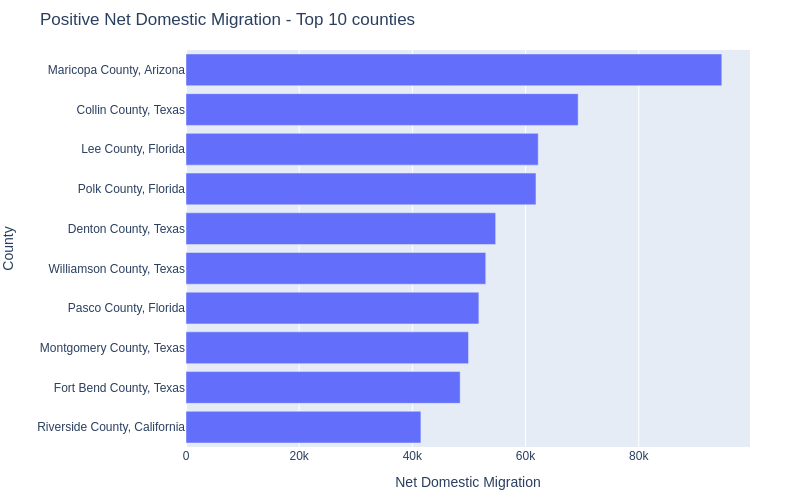

In [23]:
df_top_10 = df_merged.sort_values('domestic', ascending=False)[['domestic', 'county_name', 'state_name']].head(10)
df_top_10['location'] = df_top_10['county_name'] + ', ' + df_top_10['state_name']
title = 'Positive Net Domestic Migration - Top 10 counties'

fig = px.bar(
    df_top_10
    , x='domestic', y='location'
    , orientation='h'
)

fig.update_layout(
    title=title,
    xaxis_title='Net Domestic Migration',
    yaxis_title='County',
    margin=dict(l=50, r=50, t=50, b=50)
)

fig['layout']['yaxis']['autorange'] = 'reversed'

show_fig()

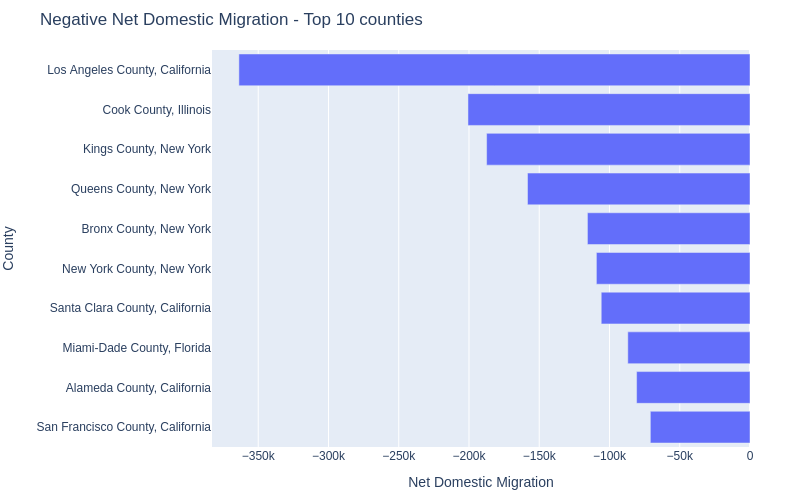

In [24]:
df_bottom_10 = df_merged.sort_values('domestic', ascending=False)[['domestic', 'county_name', 'state_name']].tail(10)
df_bottom_10['location'] = df_bottom_10['county_name'] + ', ' + df_bottom_10['state_name']
title = 'Negative Net Domestic Migration - Top 10 counties'

fig = px.bar(
    df_bottom_10
    , x='domestic', y='location'
    , orientation='h'
)

fig.update_layout(
    title=title,
    xaxis_title='Net Domestic Migration',
    yaxis_title='County',
    margin=dict(l=50, r=50, t=50, b=50)
)

show_fig()

### 6. Generate the coordinates for the dot-density map

Randomly distribute the `domestic` value throughout the counties to visualize the variation in density across the counties.

In [25]:
# recalculate the `domestic` values as 1 per 100 persons (rounded to nearest 100)
factor = 100

df_merged[['domestic']] = round(df_merged[['domestic']] / factor).astype('int')
df_merged.sort_values('domestic', ascending=False)

,domestic,county_name,state_name,geoid,geometry,minx,miny,maxx,maxy
104,947,Maricopa County,Arizona,04013,"POLYGON ((-113.33506 33.56654, -113.33331 34.0...",-113.335057,32.505188,-111.039976,34.048170
2567,693,Collin County,Texas,48085,"POLYGON ((-96.84185 33.08646, -96.83779 33.262...",-96.844122,32.981752,-96.295413,33.405498
356,622,Lee County,Florida,12071,"MULTIPOLYGON (((-82.17984 26.69666, -82.17352 ...",-82.271699,26.316245,-81.562180,26.789516
374,618,Polk County,Florida,12105,"POLYGON ((-82.10621 28.25924, -82.05553 28.258...",-82.106206,27.643238,-81.131044,28.361868
2585,547,Denton County,Texas,48121,"POLYGON ((-97.39267 33.18351, -97.38309 33.430...",-97.398459,32.987435,-96.834110,33.430450
...,...,...,...,...,...,...,...,...,...
1832,-1157,Bronx County,New York,36005,"POLYGON ((-73.92901 40.88958, -73.91970 40.913...",-73.933406,40.785357,-73.765822,40.917577
1870,-1584,Queens County,New York,36081,"POLYGON ((-73.96248 40.73680, -73.93638 40.776...",-73.962478,40.542896,-73.701633,40.805790
1853,-1875,Kings County,New York,36047,"POLYGON ((-74.04241 40.62485, -74.03834 40.637...",-74.042412,40.566803,-73.833041,40.739262
612,-2007,Cook County,Illinois,17031,"POLYGON ((-88.26364 42.06687, -88.23819 42.066...",-88.263641,41.469839,-87.524044,42.154260


In [26]:
# add a column to denote a positive or negative net migration
df_merged['net_migration'] = df_merged['domestic'].apply(lambda x: 'positive' if x>0 else 'negative')
df_merged

,domestic,county_name,state_name,geoid,geometry,minx,miny,maxx,maxy,net_migration
0,8,Autauga County,Alabama,01001,"POLYGON ((-86.91760 32.66417, -86.81657 32.660...",-86.921145,32.308632,-86.411172,32.707386,positive
1,155,Baldwin County,Alabama,01003,"POLYGON ((-88.02927 30.22271, -88.02399 30.230...",-88.029272,30.221132,-87.366601,31.319007,positive
2,-3,Barbour County,Alabama,01005,"POLYGON ((-85.74142 31.61961, -85.72983 31.632...",-85.748251,31.618048,-85.049343,32.147931,negative
3,-1,Bibb County,Alabama,01007,"POLYGON ((-87.42194 33.00338, -87.31854 33.006...",-87.421936,32.831522,-86.876118,33.246907,negative
4,8,Blount County,Alabama,01009,"POLYGON ((-86.96211 33.86769, -86.94766 33.861...",-86.963358,33.765316,-86.303516,34.260185,positive
...,...,...,...,...,...,...,...,...,...,...
3139,-10,Sweetwater County,Wyoming,56037,"POLYGON ((-110.05371 42.27074, -109.75069 42.2...",-110.054409,40.997330,-107.503821,42.270744,negative
3140,-4,Teton County,Wyoming,56039,"POLYGON ((-111.05533 44.66626, -111.00075 44.6...",-111.055333,43.235178,-110.051437,44.666722,negative
3141,2,Uinta County,Wyoming,56041,"POLYGON ((-111.04655 41.25163, -111.04655 41.2...",-111.046723,40.994746,-110.048000,41.579845,positive
3142,1,Washakie County,Wyoming,56043,"POLYGON ((-108.55056 44.16846, -107.72202 44.1...",-108.550758,43.500286,-107.110734,44.168455,positive


In [27]:
from shapely.geometry import Point

# function to randomly distribute coordinates within the county geometry
def random_coordinates(row):
    results = []
    count = 0
    val = row['domestic']
    net_migration = row['net_migration']
    while count < abs(val):
        x = random.uniform(row['minx'], row['maxx'])
        y = random.uniform(row['miny'], row['maxy'])
        pt = Point(x, y)
        if pt.within(row['geometry']):
            count += 1
            results.append([net_migration, x, y])
    return pd.DataFrame(results, columns=('net_migration', 'x', 'y'))

In [28]:
# apply the function to every row of the merged dataframe
results = df_merged.apply(random_coordinates, axis=1)

# unpack the series and concatenate the dataframes
results = pd.concat(results.tolist(), ignore_index=True)

# write to csv
out_csv = 'data/net-domestic-migration-dots-100.csv'
results.to_csv(out_csv, index=False)

In [29]:
results

,net_migration,x,y
0,positive,-86.811732,32.452485
1,positive,-86.457925,32.540164
2,positive,-86.765096,32.394060
3,positive,-86.623519,32.540587
4,positive,-86.551464,32.633577
...,...,...,...
76713,negative,-110.762886,44.465061
76714,positive,-110.546367,41.104773
76715,positive,-110.308867,41.464077
76716,positive,-107.421719,43.756059


### 6. Import into QGIS and export the map

![QGIS](images/qgis.png)

![Net Domestic Migration by County: 2020-2022](images/net-domestic-migration-dots-100.png)